In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pywt
import scipy.stats
import collections
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
seed = 23

In [2]:
def calculate_entropy(list_values):
    counter_values = collections.Counter(list_values).most_common()
    probabilities = [elem[1]/len(list_values) for elem in counter_values]
    entropy=scipy.stats.entropy(probabilities)
    return entropy

def calculate_statistics(list_values):
    n5 = np.nanpercentile(list_values, 5)
    n25 = np.nanpercentile(list_values, 25)
    n75 = np.nanpercentile(list_values, 75)
    n95 = np.nanpercentile(list_values, 95)
    median = np.nanpercentile(list_values, 50)
    mean = np.nanmean(list_values)
    std = np.nanstd(list_values)
    var = np.nanvar(list_values)
    rms = np.nanmean(np.sqrt(np.array(list_values)**2))
    return [n5, n25, n75, n95, median, mean, std, var, rms]

def calculate_crossings(list_values):
    zero_crossing_indices = np.nonzero(np.diff(np.array(list_values)> 0))[0]
    no_zero_crossings = len(zero_crossing_indices)
    mean_crossing_indices = np.nonzero(np.diff(np.array(list_values)>np.nanmean(list_values)))[0]
    no_mean_crossings = len(mean_crossing_indices)
    return [no_zero_crossings, no_mean_crossings]

def get_features(list_values):
    entropy = calculate_entropy(list_values)
    crossings = calculate_crossings(list_values)
    statistics = calculate_statistics(list_values)
    return [entropy] + crossings + statistics

In [3]:
def main(data,cond):
    
    # Putting all the samples in an array
    array=np.array(data.Samples)
    
    # Defining Wavelet 
    w = pywt.Wavelet('sym20')

    # Getting Approximation Coefficients
    lst_A_coeff = []
    max_levels = pywt.dwt_max_level(len(array),'sym20')
    
    for i in range(1, max_levels + 1):
        temp = pywt.wavedec(pd.Series(array), 'sym20', mode="per",level=i)
        lst_A_coeff.append(temp[0])
    
    
    # Feature Extraction From Approximation Coefficients
    feature_list=[]
    for i in range(0,max_levels):
        feature_list.append(get_features(list(lst_A_coeff[i])))
        
    flr=[]
    for j in range(0,12):
        temp_lst=[]
        for i in range(0,max_levels):
            temp_lst.append(feature_list[i][j])
        flr.append(temp_lst)

    
    dic={'Entropy':flr[0],'Zero crossings':flr[1],'Mean crossings':flr[2],'n5':flr[3],
    'n25':flr[4],'n75':flr[5],'n95':flr[6],'Median':flr[7],'Mean':flr[8],
    'Std':flr[9],'Var':flr[10],'Rms':flr[11]}
    
    dataframe=pd.DataFrame(dic)
    dataframe["Condition"]=cond
    return dataframe

In [4]:
file_names=["Motor (Healthy 450W).csv","Motor (Healthy 600W).csv","Motor (Healthy 760W).csv","Motor (Healthy 1100W).csv","Motor (Healthy 1500W).csv",
            "Motor 1(Healthy) 50% load.csv","Motor 1(Healthy) 80% load.csv","Motor 1(Healthy) 90% load.csv","Motor 2(Healthy) 50% load.csv","Motor 2(Healthy) 80% load.csv",
            "Motor 2(Healthy) 90% load.csv","Motor 1(BRB 450W).csv","Motor 1(BRB 600W).csv","Motor 1(BRB 50% load).csv","Motor 1(BRB 1000W).csv","Motor 1(BRB 1100W).csv","Motor 1(BRB 80% load).csv",
            "Motor 1(BRB 90% load).csv","Motor 1(BRB 1500W).csv","Motor 2(BF 50% load).csv","Motor 2(BF 80% load).csv","Motor 2(BF 90% load).csv",
            "Motor 2(BF 600W).csv","Motor 2(BF 1000W).csv"]

condition=[0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,2,2,2,2,2]

In [5]:
data_frames=[]

for i in range(0,24):
    data=pd.read_csv(file_names[i])
    data_frames.append(main(data,condition[i]))
    
pd.options.display.max_columns=150
pd.options.display.max_rows=150
dataframe= pd.concat([i for i in data_frames],axis=0,ignore_index=True)

In [6]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288 entries, 0 to 287
Data columns (total 13 columns):
Entropy           288 non-null float64
Zero crossings    288 non-null int64
Mean crossings    288 non-null int64
n5                288 non-null float64
n25               288 non-null float64
n75               288 non-null float64
n95               288 non-null float64
Median            288 non-null float64
Mean              288 non-null float64
Std               288 non-null float64
Var               288 non-null float64
Rms               288 non-null float64
Condition         288 non-null int64
dtypes: float64(10), int64(3)
memory usage: 29.3 KB


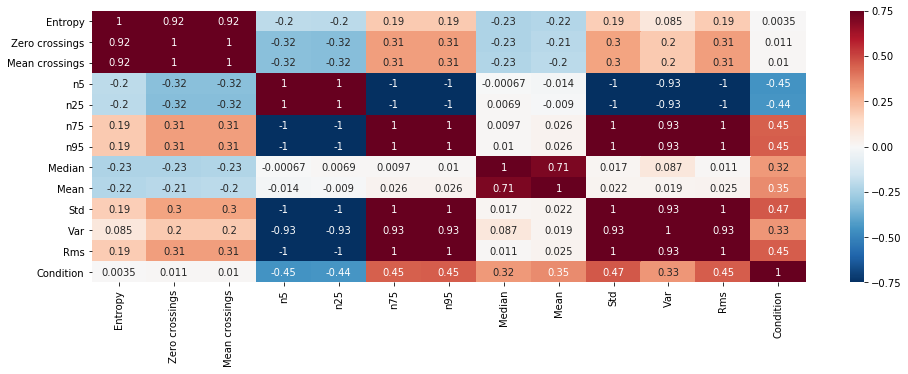

In [7]:
correlation = dataframe.corr()
plt.figure(figsize=(16, 5))
heatmap = sns.heatmap(correlation, annot=True, linewidths=0, vmin=-0.75, vmax=0.75, cmap="RdBu_r")

In [8]:
# Feature Engineering
# Multi Collinearity removal using Principal Component Analysis

dataframe.drop(["Entropy","Zero crossings","Mean crossings"],axis=1,inplace=True)
X = dataframe[["n5","n25","n75","n95","Std","Var","Rms","Median","Mean"]]
dataframe.drop(["Median","Mean","n5","n25","n75","n95","Std","Var","Rms"],axis=1,inplace=True)

In [9]:
pca = PCA().fit(X)
np.cumsum(pca.explained_variance_ratio_)

array([0.99999738, 0.99999999, 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        ])

In [10]:
pca = PCA(n_components=4)
components = pca.fit_transform(X)
principal_df = pd.DataFrame(data = components,columns = ['principal component 1',
                                                         'principal component 2',
                                                         'principal component 3',
                                                         'principal component 4'])

In [11]:
df= pd.concat([principal_df,dataframe],axis=1,ignore_index=True)

In [12]:
df.rename(columns={0:"PC1",1:"PC2",2:"PC3",3:"PC4",4:"Condition"},inplace=True)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288 entries, 0 to 287
Data columns (total 5 columns):
PC1          288 non-null float64
PC2          288 non-null float64
PC3          288 non-null float64
PC4          288 non-null float64
Condition    288 non-null int64
dtypes: float64(4), int64(1)
memory usage: 11.3 KB


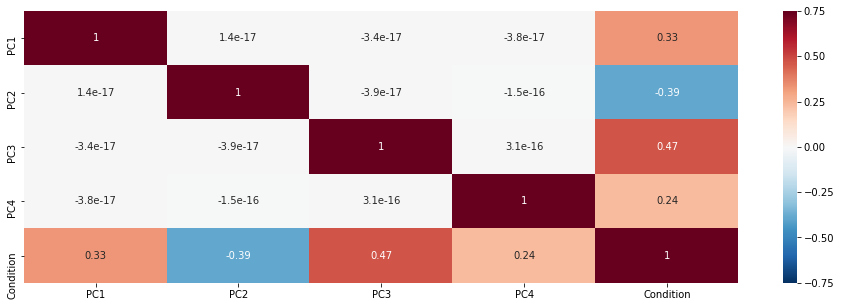

In [14]:
# After Feature Selection
correlation = df.corr()
plt.figure(figsize=(16, 5))
heatmap = sns.heatmap(correlation, annot=True, linewidths=0, vmin=-0.75, vmax=0.75, cmap="RdBu_r")

In [15]:
# test-train split

test_size = 0.20
X=df.loc[:,"PC1":"PC4"]
Y=df.loc[:,"Condition"]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

In [16]:
# KNN classifier
model_2= KNeighborsClassifier(algorithm='auto',leaf_size= 1,metric='minkowski',n_neighbors=7,weights='distance')
model_2.fit(X_train, Y_train)

# make predictions for test data
y_pred_2 = model_2.predict(X_test)
predictions_2 = [(value) for value in y_pred_2]

# evaluate predictions
accuracy = accuracy_score(Y_test, predictions_2)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 67.24%


In [45]:
n_estimators = [100, 200, 300, 400, 500]
learning_rate = [0.001, 0.01, 0.1,0.2]
objective = ["multi:softprob","multi:softmax"]
booster = ["gbtree", "gblinear", "dart"]
hyperparameters = dict(n_estimators=n_estimators, learning_rate=learning_rate, 
                       objective=objective,booster=booster)
# fit model no training data
model = XGBClassifier(eval_metric="error")
clf = GridSearchCV(model, hyperparameters)
best_model=clf.fit(X_train, Y_train)

# make predictions for test data
y_pred = clf.predict(X_test)
predictions = [(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(Y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 88.89%


In [46]:
best_model.best_estimator_.get_params()

{'objective': 'multi:softprob',
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': 'gain',
 'interaction_constraints': '',
 'learning_rate': 0.01,
 'max_delta_step': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 500,
 'n_jobs': 0,
 'num_parallel_tree': 1,
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': None,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None,
 'eval_metric': 'error'}

In [37]:
leaf_size = list(range(1,50))
n_neighbors = list(range(1,30))
p=[1,2]
weights=["uniform","distance"]
hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p,weights=weights)

knn = KNeighborsClassifier()
clf = GridSearchCV(knn, hyperparameters,scoring="neg_log_loss")

# fit model no training data
best_model=clf.fit(X_train, Y_train)
y_pred = clf.predict(X_test)
predictions = [(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(Y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 77.78%


In [38]:
best_model.best_estimator_.get_params()

{'algorithm': 'auto',
 'leaf_size': 1,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 7,
 'p': 1,
 'weights': 'distance'}

In [36]:
# fit model no training data
model = LogisticRegression(max_iter=200000)
model.fit(X_train, Y_train)
y_pred = model.predict(X_test)
predictions = [(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(Y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 65.28%
